In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Имитационное моделирование

В этом ноутбуке исследуем и валидируем имитационную модель, позволяющую рассчитать вероятность идентификации и другие характеристики нашей системы.

In [8]:
from tabulate import tabulate
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

In [9]:
from rfidam.simulation import ModelParams, build_scenario_info
from rfidam.protocol.protocol import LinkProps, Protocol
from rfidam.protocol.symbols import DR, TagEncoding
from rfidam.scenario import parse_scenario
from rfidam.utils import bcolors, get_err, fmt_err, highlight, pluralize

In [10]:
def fmt_header(s):
    return highlight(s, bcolors.OKBLUE)

def fmt_delim(s):
    return highlight(s, bcolors.OKCYAN)

def fmt_float(x):
    return f'{x:.4f}'

In [11]:
LINK_PROPS = LinkProps(
    tari=12.5e-6,
    rtcal=30e-6,
    trcal=35e-6,
    m=TagEncoding.M2,
    dr=DR.DR_643,
    trext=False,
    q=4,
    use_tid=True,
    t_off=0.1)
PROTOCOL = Protocol(LINK_PROPS)

In [6]:
def build_params(scenario: str, ber: float, arrival_interval: float, num_tags: int, time_in_area: float):
    return ModelParams( 
        protocol=PROTOCOL, 
        arrival_interval=arrival_interval,
        time_in_area=time_in_area,
        scenario=parse_scenario(scenario),
        ber=ber
    )

In [7]:
from rfidam.cy_ext.simulation import simulate
# from rfidam.simulation import simulate

def run_sim(params, n_iters = 5):
    journals = [simulate(params, only_id=False) for _ in tqdm(range(n_iters))]
    return journals

In [8]:
BER = .002
ARRIVAL_INTERVAL = .5
TIME_IN_AREA = 2.42

In [9]:
params = build_params("ABABx", ber=BER, arrival_interval=ARRIVAL_INTERVAL, num_tags=10000, time_in_area=TIME_IN_AREA)

In [10]:
journals_1 = run_sim(params, n_iters=2)

  0%|          | 0/2 [00:00<?, ?it/s]

In [11]:
round_infos_x3 = build_scenario_info(journals_1, len(params.scenario) * 3 )

### Build analytic results for the same data


In [12]:
from rfidam.chains import estimate_rounds_props
from rfidam.statistics import count_averages, group_round_values

SCENARIO_MULTIPLIER = 200

rounds_props = estimate_rounds_props(params.scenario*SCENARIO_MULTIPLIER, 
                                     params.protocol, 
                                     ber=BER, 
                                     arrival_interval=ARRIVAL_INTERVAL, 
                                     time_in_area=TIME_IN_AREA)
rounds_props['n_active_tags_stats'] = count_averages(
    group_round_values(
        [p @ np.arange(p.shape[0]) for p in rounds_props['n_active_tags']], 
        len(params.scenario)*3
    ))

### Estimate identification probability

In [13]:
from rfidam.scenario import mark_scenario
from rfidam.chains import estimate_id_probs

marked_scenario = mark_scenario(
    params.scenario*SCENARIO_MULTIPLIER, 
    arrival_interval=ARRIVAL_INTERVAL, 
    time_in_area=TIME_IN_AREA, 
    durations=rounds_props['durations'], 
    t0=50.)

# for i, spec in enumerate(marked_scenario):
#     print(f"{i}: {spec} {' <--- HIT' if spec.n_arrived > 0 else ''}")

avg_id_prob, id_probs_map = estimate_id_probs(
    n_tags_probs=rounds_props['n_active_tags'],
    scenario=marked_scenario,
    durations=rounds_props['durations'],
    ber=BER,
    protocol=PROTOCOL,
    time_in_area=TIME_IN_AREA
)
sim_id_prob = round_infos_x3.id_probs.mean()
print("AVERAGE ID PROB:  ", avg_id_prob)
print("... FROM SIM.  :  ", sim_id_prob, f" (error: {abs(avg_id_prob - sim_id_prob) / sim_id_prob})")
# print("ID PROBS MAPPING: ", id_probs_map)

AVERAGE ID PROB:   0.9999999999995831
... FROM SIM.  :   1.0  (error: 4.168887457467463e-13)


### Visualize

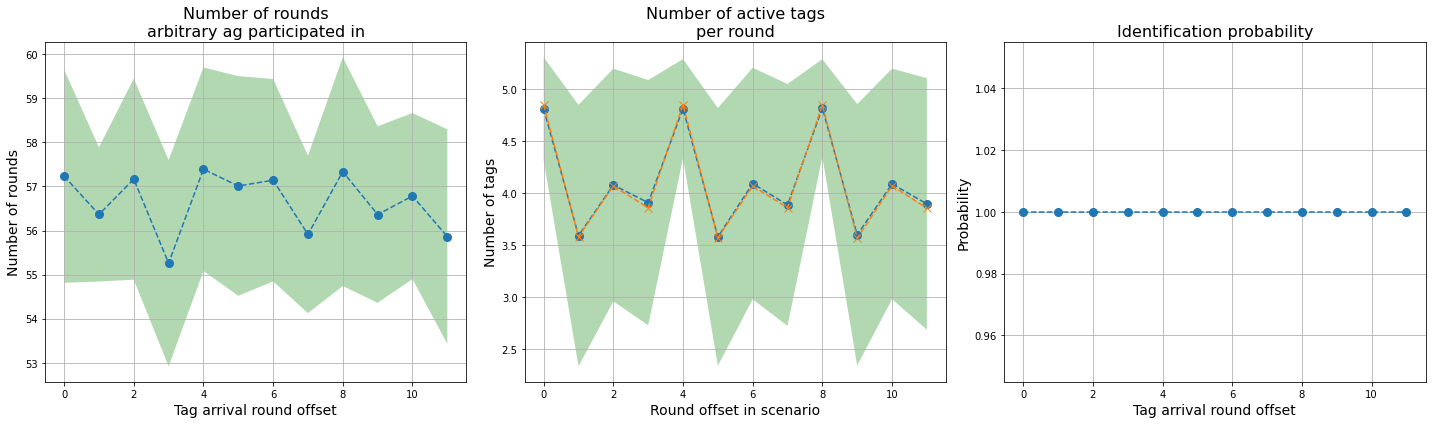

In [14]:
fig, axes = plt.subplots(figsize=(20, 6), ncols=3)
OX = np.arange(round_infos_x3.scenario_length)
axes[0].plot(OX, round_infos_x3.num_rounds_active.means, marker='o', markersize=8, linestyle='--')
axes[0].fill_between(
    OX, 
    round_infos_x3.num_rounds_active.means - round_infos_x3.num_rounds_active.errors, 
    round_infos_x3.num_rounds_active.means + round_infos_x3.num_rounds_active.errors, 
    facecolor='green', alpha=0.3)
axes[0].set_title("Number of rounds\narbitrary ag participated in", fontsize=16)
axes[0].set_xlabel('Tag arrival round offset', fontsize=14)
axes[0].set_ylabel('Number of rounds', fontsize=14)

axes[1].plot(OX, round_infos_x3.num_tags_active.means, marker='o', markersize=8, linestyle='--')
axes[1].plot(OX, rounds_props['n_active_tags_stats'].means, marker='x', markersize=8, linestyle='--')
axes[1].fill_between(
    OX, 
    round_infos_x3.num_tags_active.means - round_infos_x3.num_tags_active.errors, 
    round_infos_x3.num_tags_active.means + round_infos_x3.num_tags_active.errors, 
    facecolor='green', alpha=0.3)
axes[1].set_title("Number of active tags\nper round", fontsize=16)
axes[1].set_xlabel('Round offset in scenario', fontsize=14)
axes[1].set_ylabel('Number of tags', fontsize=14)

axes[2].plot(OX, round_infos_x3.id_probs, marker="o", markersize=8, linestyle='--')
axes[2].set_title('Identification probability', fontsize=16)
axes[2].set_xlabel('Tag arrival round offset', fontsize=14)
axes[2].set_ylabel('Probability', fontsize=14)

for ax in axes:
    ax.grid()

plt.tight_layout()

# Расчет зависимости идентификации от BER

> **TODO: поменять Q, чтобы число меток могло быть сравнимо с числом слотов (или больше)**

> **TODO: добавить сценарии типа AABB, AAAABBBB, Ax, AAx, AAAAAAAAx**

> **TODO: добавить распараллеливание и запись результатов в файл**

In [13]:
#!pip install pandas

In [67]:
import os
import pandas as pd

FILE_NAME = os.path.join("data", "id_prob.csv")
FORCE_COMPUTE = False

will_run = not os.path.exists(FILE_NAME) or FORCE_COMPUTE

if will_run:
    print(f"File {FILE_NAME}{' ' if os.path.exists(FILE_NAME) else ' not'} found, FORCE_COMPUTE={FORCE_COMPUTE}. "
          f"File will be generated, simulations and estimations will be executed.")
else:
    print(f"File {FILE_NAME} found, it will be used without running simulations.")

File data/id_prob.csv found, it will be used without running simulations.


Определим параметры, которые не будут меняться между симуляциями. К таким параметрам относится все, что касается линков `R => T` и `T => R`:
так как в нашей модели BER фиксируется, то увеличение `Tari` или `M` приведет только к увеличению длины раунда (и уменьшению числа раундов),
но не будет влиять на BER, поэтому их учет не даст полезной информации. 

Выбранные параметры приблизительно соответствуют тем, которые используются в эксперименте.

> **ВНИМАНИЕ! Эти параметры не сохраняются в CSV-файле, поэтому после их изменения нужно явно сказать, что экспермент нужно пересчитать.**

In [68]:
from rfidam.protocol import symbols

# Protocol parameters
# -------------------
TARI = 12.5e-6
RTCAL = 3 * TARI
TRCAL = 1.5 * RTCAL
M = symbols.TagEncoding.M2
DR = symbols.DR.DR_643
DR_S = f"'{symbols.DR.str(DR)}'"
Q = 2
T_OFF = .1

# Other parameters
# ----------------
TIME_IN_AREA = 2.5
BER_MIN = .001
BER_MAX = .05
N_BER_POINTS = 21

# Environment and simulation-related parameters:
# ----------------------------------------------
RFIDAM_PY = os.path.join('..', 'rfidam', 'main.py')  # main script
N_WORKERS = 8               # number of worker processes
N_SIM_TAGS = 5000           # number of tags to simulate
SCENARIO_MULTIPLIER = 1000  # number the scenario copies in analytics

Теперь определим параметры, которые будут меняться. Это:

- интервалы между поступлениями меток
- BER
- сценарии

In [74]:
import itertools

if will_run:
    ARRIVAL_INTERVALS = [.2, .8, 1.2]
    SCENARIOS = ["A", "Ax", "AAx", "AAAAx", "AAAAAAAAx", 
                 "AB", "AABB", "AAAABBBB", "AAAAAAAABBBBBBBB", 
                 "ABx", "AAABxAAxABABx"]
    BER = np.linspace(BER_MIN, BER_MAX, N_BER_POINTS)
    
    df = pd.DataFrame([
        {
            'ber': ber,
            'interval': interval,
            'scenario': scenario,
            'id_type': id_type,
            'p_sim': 0.0,
            'p_ana': 0.0,
        }
        for ber, interval, scenario, id_type in itertools.product(BER, ARRIVAL_INTERVALS, SCENARIOS, ["EPCID", "TID"])
    ])
    df.to_csv(FILE_NAME, index=False)
    
    # Execute simulation:
    print(f"[*] running {len(df)} simulations")
    %run ../rfidam/main.py batch simulate $FILE_NAME --jupyter \
        -j $N_WORKERS --num-tags $N_SIM_TAGS \
        --tari $TARI --rtcal $RTCAL --trcal $TRCAL \
        -q $Q --tag-encoding $M.value \
        --dr $DR_S --time-in-area $TIME_IN_AREA --time-off $T_OFF
    
    # Execute analytic estimations:
    print(f"[*] running {len(df)} analytic estimations")
    %run ../rfidam/main.py batch solve $FILE_NAME --jupyter \
        -j $N_WORKERS --ext-mul $SCENARIO_MULTIPLIER \
        --tari $TARI --rtcal $RTCAL --trcal $TRCAL \
        -q $Q --tag-encoding $M.value \
        --dr $DR_S --time-in-area $TIME_IN_AREA --time-off $T_OFF
    
    df = pd.read_csv(FILE_NAME)
    
else:
    # Если CSV-файл существует, то мы получаем все сценарии, интервалы и 
    # значения BER из этого файла
    df = pd.read_csv(FILE_NAME)
    ARRIVAL_INTERVALS = list(df.interval.unique())
    SCENARIOS = list(df.scenario.unique())
    BER = list(df.ber.unique())
    ARRIVAL_INTERVALS.sort()
    BER.sort()    

In [83]:
from matplotlib.pyplot import get_cmap

CMAP = get_cmap('viridis')

def plot_id_probs(scenario, show_suptitle=False, save=False, fmt="pdf"):
    n_intervals = len(ARRIVAL_INTERVALS)
    
    _df = df[df.scenario == scenario]
    _dfs_tid, _dfs_epc = [], []
    for interval in ARRIVAL_INTERVALS:
        _dfs_tid.append(_df[(_df.interval == interval) & (_df.id_type == "TID")])
        _dfs_epc.append(_df[(_df.interval == interval) & (_df.id_type == "EPCID")])
    
    fig, axes = plt.subplots(figsize=(16, 4), ncols=n_intervals, nrows=1, sharey=True)
    
    sim_epc_kwargs = {'linestyle': '', 'marker': 'v', 'markersize': 6, 'color': CMAP(0.2)}
    sim_tid_kwargs = {'linestyle': '', 'marker': '^', 'markersize': 6, 'color': CMAP(0.8)}
    ana_epc_kwargs = {'linestyle': '--', 'color': CMAP(0.2)}
    ana_tid_kwargs = {'linestyle': '-', 'color': CMAP(0.8)}
    
    axes[0].set_ylabel("Вероятность", fontsize=16)
    for i, interval in enumerate(ARRIVAL_INTERVALS):
        _dt, _de = _dfs_tid[i], _dfs_epc[i]
        axes[i].plot(_dt.ber, _dt.p_ana, **ana_tid_kwargs, label="TID (аналитика)")
        axes[i].plot(_dt.ber, _dt.p_sim, **sim_tid_kwargs, label="TID (симуляция)")
        axes[i].plot(_de.ber, _de.p_ana, **ana_epc_kwargs, label="EPCID (аналитика)")
        axes[i].plot(_de.ber, _de.p_sim, **sim_epc_kwargs, label="EPCID (симуляция)")

        axes[i].set_title(f"Интервал {interval} сек.", fontsize=18)
        axes[i].tick_params(labelsize=14)
        axes[i].set_xlabel("BER", fontsize=16)
        axes[i].grid()
        
    axes[-1].legend(loc="center left", bbox_to_anchor=(1,0.5), fontsize=16, ncol=1)
    
    if show_suptitle:
        fig.suptitle(f'Вероятность идентификациии для сценария "{scenario}"', fontsize=22)
    
    plt.tight_layout()
    
    if save:
        plt.savefig(f"id_prob_{scenario}.{fmt}")

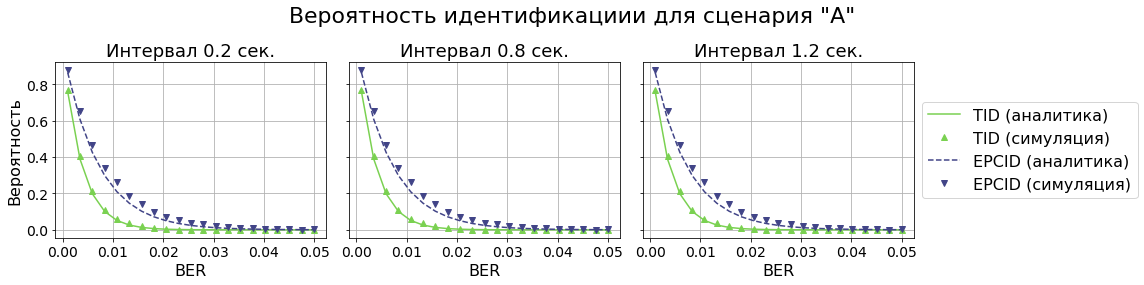

In [84]:
plot_id_probs("A", show_suptitle=True, save=False)

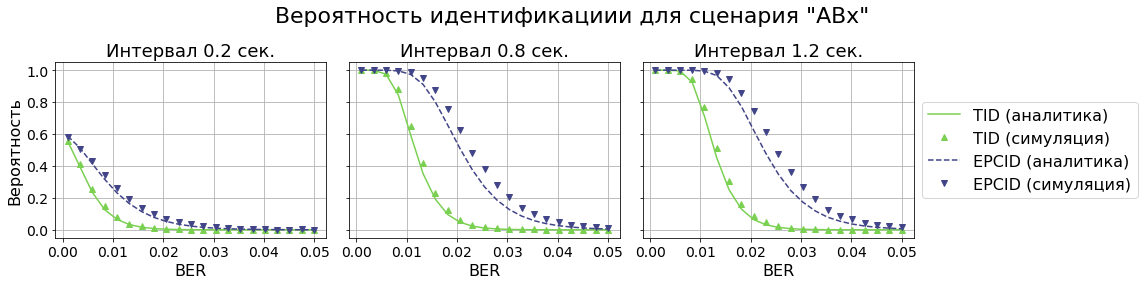

In [86]:
plot_id_probs("ABx", show_suptitle=True, save=False)

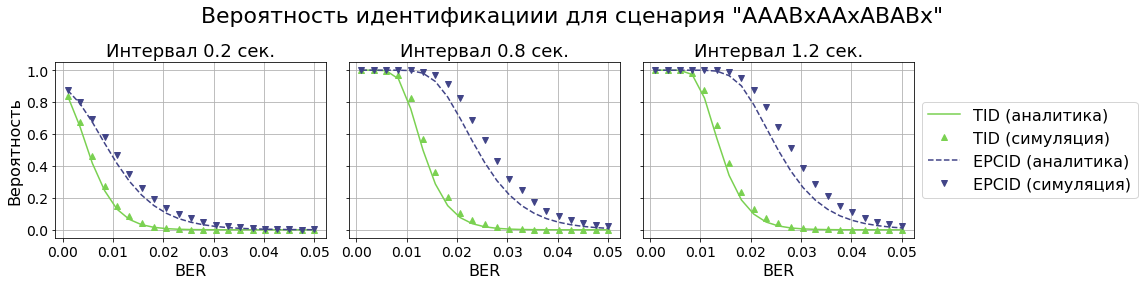

In [87]:
plot_id_probs("AAABxAAxABABx", show_suptitle=True, save=False)

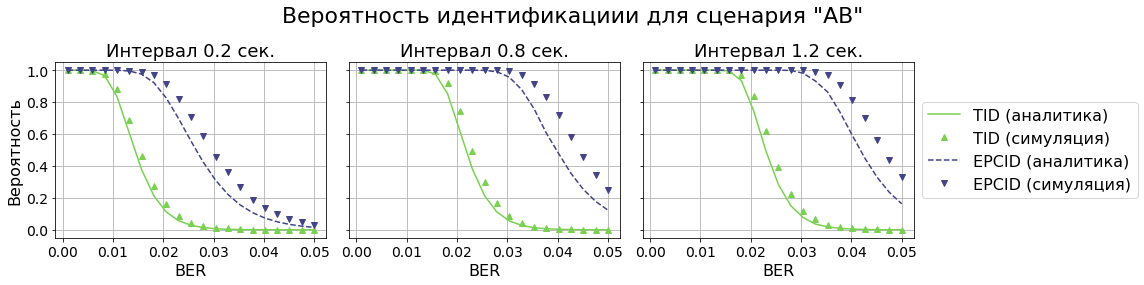

In [102]:
plot_id_probs("AB", show_suptitle=True, save=False)

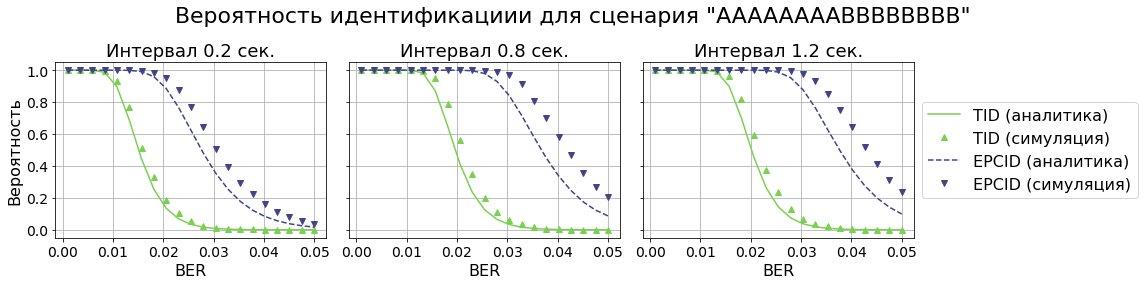

In [103]:
plot_id_probs("AAAAAAAABBBBBBBB", show_suptitle=True, save=False)

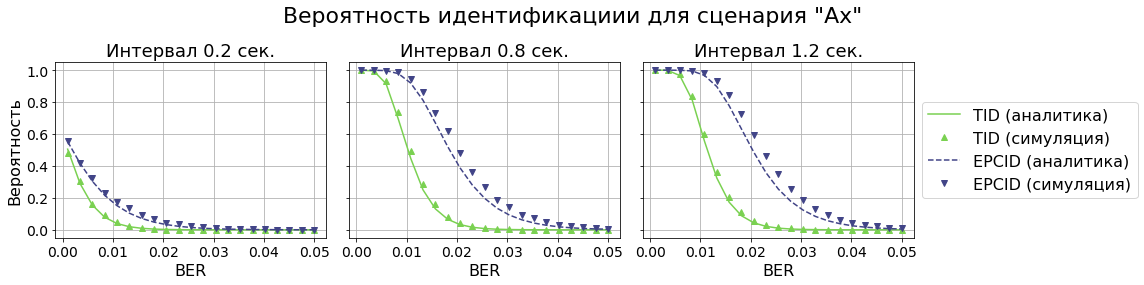

In [104]:
plot_id_probs("Ax", show_suptitle=True, save=False)

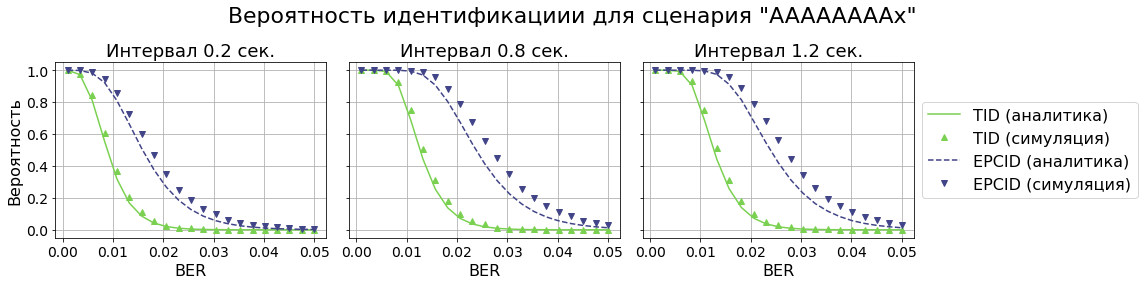

In [105]:
plot_id_probs("AAAAAAAAx", show_suptitle=True, save=False)